In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, Flatten, BatchNormalization, MaxPooling2D, concatenate, Dropout, Lambda, RepeatVector, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
import numpy as np
import os
import tensorflow as tf
import cv2
import imutils
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from scipy.interpolate import make_interp_spline
import seaborn as sns

In [ ]:
!unzip /content/drive/MyDrive/DATASET.zip

Streaming output truncated to the last 5000 lines.
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_7998.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_8270.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_833.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_8489.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_8496.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_8508.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_8819.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_8937.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_8997.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_9001.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_9042.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_9226.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_9627.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_9767.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_7_9823.txt  
  inflating: DATASET/TRAIN/VECTORS/LYMPHOCYTE/_8_1

In [ ]:
images96 = []
vectors = []
labels = []

In [ ]:
images64 = []

In [ ]:
images229 = []

In [ ]:
code={"EOSINOPHIL":0,"LYMPHOCYTE":1,"MONOCYTE":2,"NEUTROPHIL":3}


def findedges(image):
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged

def getimageconturs(edged):
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

def getboxes(contours,orig):
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (np.linalg.norm(tl - bl)) > 0 and (np.linalg.norm(tl - tr)) > 0:
            boxes.append(box)
    return boxes

def getcode(n):
    if type(n)==str:
        for x,y in code.items():
            if n==x:
                return y
    else:
        for x,y in code.items():
            if n==y:
                return x

In [ ]:
def load_and_preprocess_data(images_path, path):

    for label, folder_path in enumerate(path):
        vec_files = os.listdir(folder_path)
        for vec_file in vec_files:
            filename = vec_file.split(".")[0]
            class_name = getcode(label)
            image_path = f"{images_path}/{class_name}/{filename}.jpeg"
            vector_path = f"{folder_path}{vec_file}"

            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # add padding to the image to better detect cell at the edge
            image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])

            #thresholding the image to get the target cell
            image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))

            # openning errosion then dilation
            kernel = np.ones((3, 3), np.uint8)
            kernel1 = np.ones((5, 5), np.uint8)
            img_erosion = cv2.erode(image1, kernel, iterations=2)
            image1 = cv2.dilate(img_erosion, kernel1, iterations=5)

            #detecting the blood cell
            edgedImage = findedges(image1)
            edgedContours = getimageconturs(edgedImage)
            edgedBoxes =  getboxes(edgedContours, image.copy())

            if len(edgedBoxes)==0:
                continue
            # get the large box and get its cordinate
            last = edgedBoxes[-1]
            max_x = int(max(last[:,0]))
            min_x = int( min(last[:,0]))
            max_y = int(max(last[:,1]))
            min_y = int(min(last[:,1]))

            # draw the contour and fill it
            mask = np.zeros_like(image)
            cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1)

            # any pixel but the pixels inside the contour is zero
            image[mask==0] = 0

            # extract th blood cell
            image = image[min_y:max_y, min_x:max_x]

            if (np.size(image)==0):
                continue
            # resize th image

            image64 = cv2.resize(image, (64,64))
            image64 = image64 / 255.0

            images64.append(image64)

            image96 = cv2.resize(image, (96,96))
            image96 = image96 / 255.0

            images96.append(image96)

            image229 = cv2.resize(image, (229,229))
            image229 = image229 / 255.0

            images229.append(image229)

            vector = np.loadtxt(vector_path, delimiter=',')


            vectors.append(vector)
            labels.append(label)


In [ ]:
test_paths = [
    '/content/DATASET/TEST/VECTORS/EOSINOPHIL/',
    '/content/DATASET/TEST/VECTORS/LYMPHOCYTE/',
    '/content/DATASET/TEST/VECTORS/MONOCYTE/',
    '/content/DATASET/TEST/VECTORS/NEUTROPHIL/'
]

In [ ]:
load_and_preprocess_data("/content/DATASET/TEST/IMAGES", test_paths)

In [ ]:
images64 = np.array(images64, dtype = 'float32')
images96 = np.array(images96, dtype = 'float32')
images229 = np.array(images229, dtype = 'float32')
vectors = np.array(vectors, dtype = 'float32')
labels = np.array(labels, dtype = 'int32')

In [ ]:
print(images64.shape, images96.shape, images229.shape, vectors.shape, labels.shape)

(2426, 64, 64, 3) (2426, 96, 96, 3) (2426, 229, 229, 3) (2426, 10) (2426,)


In [ ]:
resnet = tf.keras.models.load_model('/content/drive/MyDrive/Pretrained Models with knowledge/ResNetPretrainedModelWithKnowledge.h5')
densenet = tf.keras.models.load_model('/content/drive/MyDrive/Pretrained Models with knowledge/DenseNetPretrainedModelWithKnowledge.h5')
mobilenet = tf.keras.models.load_model('/content/drive/MyDrive/Pretrained Models with knowledge/MobileNetV2PretrainedModelWithKnowledge.h5')
vggnet = tf.keras.models.load_model('/content/drive/MyDrive/Pretrained Models with knowledge/VGG16PretrainedModelWithKnowledge.h5')
inceptionv3 = tf.keras.models.load_model('/content/drive/MyDrive/Pretrained Models with knowledge/InceptionV3PretrainedModelWithKnowledge.h5')
phase1model =  tf.keras.models.load_model('/content/drive/MyDrive/Pretrained Models with knowledge/final_model_v64.h5')

In [ ]:
preds_resnet_model = resnet.predict([images96, vectors])
preds_densenet_model = densenet.predict([images96, vectors])
preds_mobilenet_model = mobilenet.predict([images96, vectors])
preds_vggnet_model = vggnet.predict([images96, vectors])
preds_inceptionv3_model = inceptionv3.predict([images229, vectors])
preds_phase1_model = phase1model.predict([images64, vectors])

76/76 [==============================] - 1s 5ms/step


In [ ]:
class_preds_model1 = np.argmax(preds_resnet_model, axis=1)
class_preds_model2 = np.argmax(preds_densenet_model, axis=1)
class_preds_model3 = np.argmax(preds_mobilenet_model, axis=1)
class_preds_model4 = np.argmax(preds_vggnet_model, axis=1)
class_preds_model5 = np.argmax(preds_inceptionv3_model, axis=1)
class_preds_model6 = np.argmax(preds_phase1_model, axis=1)

In [ ]:
# Define weights for each model (replace with your own weights)
weights = np.array([0.15, 0.10, 0.10, 0.15, 0.25, 0.25])

# Calculate weighted average of class probabilities
weighted_avg_probs = (weights[0] * preds_resnet_model +
                      weights[1] * preds_densenet_model +
                      weights[2] * preds_mobilenet_model +
                      weights[3] * preds_vggnet_model +
                      weights[4] * preds_inceptionv3_model +
                      weights[5] * preds_phase1_model)

# Get class predictions from weighted average probabilities
weighted_avg_preds = np.argmax(weighted_avg_probs, axis=1)

In [ ]:
# Calculate accuracy for weighted average predictions
weighted_avg_accuracy = accuracy_score(labels, weighted_avg_preds)

# print("Max Voting Accuracy:", max_voting_accuracy)
print("Weighted Average Accuracy:", weighted_avg_accuracy)

Weighted Average Accuracy: 0.9929925803792251


In [ ]:
print(weighted_avg_preds)

[0 0 0 ... 3 3 3]


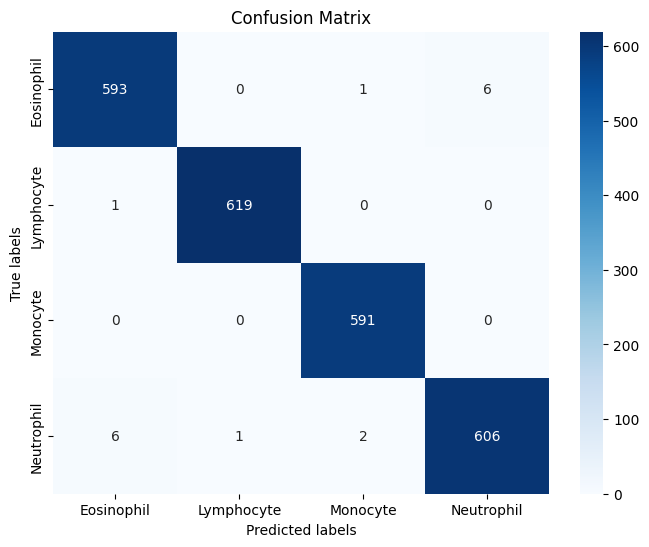

In [ ]:
cm = confusion_matrix(labels, weighted_avg_preds)

# Define class labels
classes = ['Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()